# Курсовой проект для курса "Python для Data Science"

## Info

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb). (Pull request не нужен, только ссылка ведущая на сам скрипт).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from scipy.stats import norm
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['font.size'] = '8'

from datetime import datetime
import warnings

дополнительные функции

In [2]:
# преобразование
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [69]:
def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()

In [129]:
def models_r2(models, test, valid):
    scores = pd.DataFrame(columns=['name', 'r2', 'mse'])
    for name, model in models.items():
        test_pred = model.predict(test)
        r2 = r2_score(valid, test_pred)
        mse = mean_squared_error(valid, test_pred)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = scores.append(
                {'name': name, 'r2': r2, 'mse': mse}, ignore_index=True)
        
    scores.sort_values('r2', ascending=False, inplace=True)
    return scores

загрузка данных

In [4]:
train = pd.read_csv('data_set/train.csv');
test = pd.read_csv('data_set/test.csv');

print(f"Train:\t{train.shape[0]}\tстрок\t {train.shape[1]}\t столбцов");
print(f"Test:\t{test.shape[0]}\tстрок\t {test.shape[1]}\t столбцов");

Train:	10000	строк	 20	 столбцов
Test:	5000	строк	 19	 столбцов


In [5]:
train.tail(n=3)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
9997  5123          27    1.0  47.939008         NaN            1.0     12   
9998  5400          75    2.0  43.602562   33.840147            8.0      1   
9999  6306         128    1.0  38.666645   21.157874            8.0      7   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9997        16.0       2015   0.072158         B         B         2   
9998         5.0       1961   0.307467         B         A        30   
9999        17.0       1990   0.000000         B         B        27   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
9997       629         1           NaN            0        0       A   
9998      5048         9         325.0            2        5       B   
9999      4798         0          30.0            2        8       B   

              Price  
9997  159143.805370  
9998  181595.339808  
9999  218714.077615

In [6]:
test.tail(n=3)

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
4997   5783          12    3.0  77.842178   48.282625            9.0     23   
4998   4780          62    2.0  81.305222         NaN            0.0      4   
4999  12504          30    2.0  60.555693         NaN            1.0     10   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4997        22.0       1989   0.090799         B         B        74   
4998         0.0       1977   0.072158         B         B         2   
4999        17.0       1977   0.000078         B         B        22   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
4997     19083         2           NaN            5       15       B  
4998       629         1           NaN            0        0       A  
4999      6398       141        1046.0            3       23       B

Приведение типов данных

In [7]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [8]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

изменим некоторые типы данных

In [9]:
train['Rooms'] = train['Rooms'].astype('int64')
test['Rooms'] = test['Rooms'].astype('int64')


train['HouseFloor'] = train['HouseFloor'].astype('int64')
test['HouseFloor'] = test['HouseFloor'].astype('int64')

train = optimizing_df(train)
test = optimizing_df(test)

In [10]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  uint8   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  uint8   
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

In [11]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   uint16  
 1   DistrictId     5000 non-null   uint8   
 2   Rooms          5000 non-null   uint8   
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   uint8   
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   uint8   
 17  Shops_1        5000 non-null   ui

DistrictId и Id нужно отнести к категориальным признакам.

In [12]:
train.DistrictId=train.DistrictId.astype('object')
train.Id=train.Id.astype('object')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  uint8   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  uint8   
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

Посмотрим на распределение данных

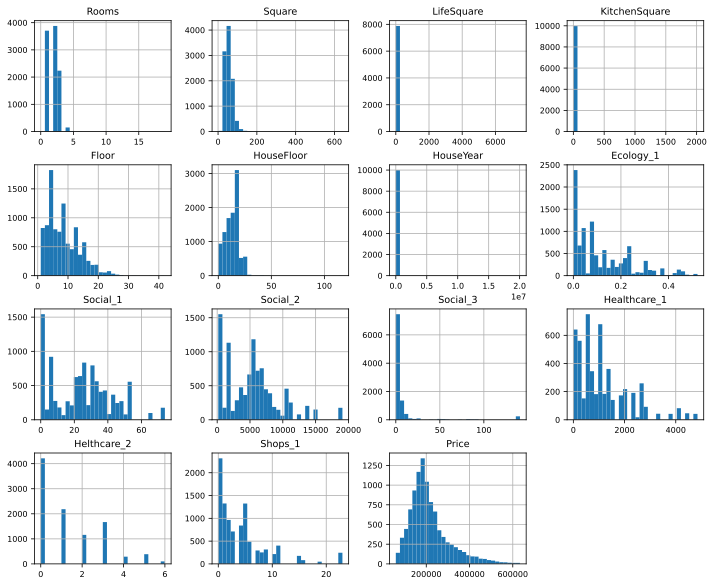

In [13]:
digital_features=train.select_dtypes(exclude=['object'])
digital_features.hist(figsize=(12,10), bins=30)
plt.show()

In [14]:
train.describe().transpose()

count           mean            std           min  \
Rooms          10000.0       1.890500       0.839512      0.000000   
Square         10000.0      56.315712      21.058718      1.136859   
LifeSquare      7887.0      37.199596      86.241112      0.370619   
KitchenSquare  10000.0       6.273300      28.561113      0.000000   
Floor          10000.0       8.526700       5.241148      1.000000   
HouseFloor     10000.0      12.609400       6.775974      0.000000   
HouseYear      10000.0    3990.166300  200500.261427   1910.000000   
Ecology_1      10000.0       0.118858       0.119026      0.000000   
Social_1       10000.0      24.687000      17.532614      0.000000   
Social_2       10000.0    5352.157400    4006.799803    168.000000   
Social_3       10000.0       8.039200      23.831875      0.000000   
Healthcare_1    5202.0    1142.904419    1021.518982      0.000000   
Helthcare_2    10000.0       1.319500       1.493601      0.000000   
Shops_1        10000.0       4.231300       4.806341      0.000000   
Price          10000.0  214139.218750   92872.304688  59174.777344   

                         25%            50%            75%           max  
Rooms               1.000000       2.000000       2.000000  1.900000e+01  
Square             41.774879      52.513309      65.900627  6.410652e+02  
LifeSquare         22.769833      32.781261      45.128803  7.480592e+03  
KitchenSquare       1.000000       6.000000       9.000000  2.014000e+03  
Floor               4.000000       7.000000      12.000000  4.200000e+01  
HouseFloor          9.000000      13.000000      17.000000  1.170000e+02  
HouseYear        1974.000000    1977.000000    2001.000000  2.005201e+07  
Ecology_1           0.017647       0.075424       0.195781  5.218670e-01  
Social_1            6.000000      25.000000      36.000000  7.400000e+01  
Social_2         1564.000000    5285.000000    7227.000000  1.908300e+04  
Social_3            0.000000       2.000000       5.000000  1.410000e+02  
Healthcare_1      350.000000     900.000000    1548.000000  4.849000e+03  
Helthcare_2         0.000000       1.000000       2.000000  6.000000e+00  
Shops_1             1.000000       3.000000       6.000000  2.300000e+01  
Price          153872.628906  192269.648438  249135.460938  6.332334e+05

### Square, LifeSquare, KitchenSquare

In [15]:
print(train['LifeSquare'].isnull().sum())
print(test['LifeSquare'].isnull().sum())

2113
1041


LifeSquare имеет значение NULL в тестовых и в тренировочных данных.

In [16]:
train.loc[train['LifeSquare'].isnull(), 'LifeSquare'] = 0
test.loc[test['LifeSquare'].isnull(), 'LifeSquare'] = 0

In [17]:
test.describe().transpose()

count         mean          std          min          25%  \
Id             5000.0  8412.595400  4832.674037     1.000000  4221.750000   
DistrictId     5000.0    51.279200    44.179466     0.000000    21.000000   
Rooms          5000.0     1.910000     0.838594     0.000000     1.000000   
Square         5000.0    56.449501    19.092793     1.378543    41.906230   
LifeSquare     5000.0    28.630507    21.613903     0.000000    17.873732   
KitchenSquare  5000.0     5.976800     9.950147     0.000000     1.000000   
Floor          5000.0     8.632000     5.483228     1.000000     4.000000   
HouseFloor     5000.0    12.601000     6.789213     0.000000     9.000000   
HouseYear      5000.0  1984.392600    18.573149  1908.000000  1973.000000   
Ecology_1      5000.0     0.119874     0.120070     0.000000     0.019509   
Social_1       5000.0    24.933800    17.532202     0.000000     6.000000   
Social_2       5000.0  5406.900000  4026.614773   168.000000  1564.000000   
Social_3       5000.0     8.262600    23.863762     0.000000     0.000000   
Healthcare_1   2623.0  1146.657227  1044.744995     0.000000   325.000000   
Helthcare_2    5000.0     1.319400     1.479940     0.000000     0.000000   
Shops_1        5000.0     4.242800     4.777365     0.000000     1.000000   

                       50%           75%           max  
Id             8320.500000  12598.250000  16795.000000  
DistrictId       37.000000     77.000000    212.000000  
Rooms             2.000000      2.000000     17.000000  
Square           52.921339     66.285130    223.453690  
LifeSquare       29.118838     41.769526    303.071106  
KitchenSquare     6.000000      9.000000    620.000000  
Floor             7.000000     12.000000     78.000000  
HouseFloor       12.000000     17.000000     99.000000  
HouseYear      1977.000000   2000.000000   2020.000000  
Ecology_1         0.072158      0.195781      0.521867  
Social_1         25.000000     36.000000     74.000000  
Social_2       5285.000000   7287.000000  19083.000000  
Social_3          2.000000      5.000000    141.000000  
Healthcare_1    900.000000   1548.000000   4849.000000  
Helthcare_2       1.000000      2.000000      6.000000  
Shops_1           3.000000      6.000000     23.000000

В тестовых данных показатель 'Square' максимально равно 223,5. Необходимо понять, сколько объектов с большей площадью в тренировочных данных.

В тестовых данных показатель 'LifeSquare' максимально равно 303,5. Необходимо понять, сколько объектов с большей площадью в тренировочных данных.

В тестовых данных показатель 'KitchenSquare' максимально равно 620. Скорее всего это ошибочное значение, но оно есть в
тестовых данных. Необходимо понять, сколько объектов с большей площадью в тренировочных данных.

In [18]:
sq = train.loc[train['Square'] > 223.5,  'Square']
lsq = train.loc[train['LifeSquare'] > 303.5,  'LifeSquare']
ksq = train.loc[train['KitchenSquare'] > 620,  'KitchenSquare']

all_data = pd.concat((sq, lsq, ksq), sort=False).reset_index(drop=True)
#len(all_data.unique())

print(f'Всего {len(all_data.unique())} Элементов, удалим их из выборки')

Всего 10 Элементов, удалим их из выборки


In [19]:
train = train.loc[train['Square'] < 223.5]
train = train.loc[train['LifeSquare'] < 303.5]
train = train.loc[train['KitchenSquare'] < 620]
train.index.size

9992

### HouseYear

In [20]:
print('--- HouseYear ---')
print(train.loc[train['HouseYear'] > datetime.now().year,  'HouseYear'])

--- HouseYear ---
1497    20052011
4189        4968
Name: HouseYear, dtype: uint32


In [21]:
# всего 2 выброса - справимся в ручную - заменим
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = 2005
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968

### Rooms

In [22]:
train['Rooms'].value_counts()

2     3878
1     3702
3     2233
4      150
5       17
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [23]:
# в выбросы подставим медиану
train.loc[train['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = train['Rooms'].median()
train['Rooms'].median()

2.0

### Foor, HouseFloor

In [24]:
# этаж выше общего количества этажей. странные данные.... но пока оставим
print(train.loc[train['Floor'] > train['HouseFloor']].index.size)

1822


In [25]:
# такие данные есть и в тестовых
print(test.loc[test['Floor'] > test['HouseFloor']].index.size)

884


### Healthcare_1

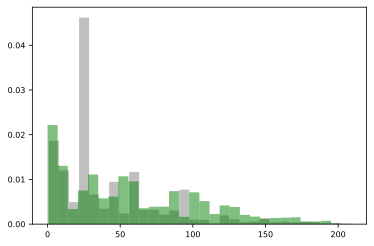

In [26]:
HC_Null = train.loc[train['Healthcare_1'].isnull(), ['DistrictId']].astype('int64')
HC_Fill = train.loc[train['Healthcare_1'].notnull(), ['DistrictId']].astype('int64')

plt.hist(HC_Null['DistrictId'].to_numpy(), bins=30, density=True, alpha=0.5, label='NULL', color='grey')
plt.hist(HC_Fill['DistrictId'].to_numpy(), bins=30, density=True, alpha=0.5, label='Not NULL', color='green')

plt.show()

Видно, что основная часть незаполненных (серых) значений находятся в кварталах с начальными номерами от 0 до 100
то и NULL вполне может быть правильным значением, заменим его на "0"

In [27]:
train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = 0
test.loc[test['Healthcare_1'].isnull(), 'Healthcare_1'] = 0

что мы имеем по незаполненыь данным

In [28]:
train.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [29]:
test.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

<AxesSubplot:>

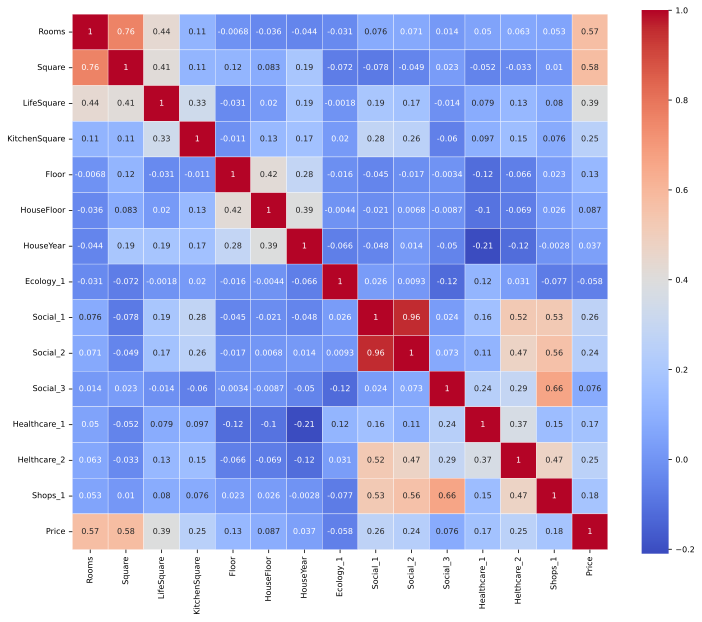

In [30]:
corrmat = train.corr()
plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, cmap='coolwarm', annot = True, linewidths=0.3, square=True)

###### Коэффициенты коррекляции в с показателем 'Price' больше всего у параметров 'Rooms' и 'Square'. Но, если выводить эти таблицы для каждого из кварталов, то картина будет немного иной и будет не совсем верно игнорировать тот факт, что цена хорошо корреклирует с общей площадью в рамках каждого квартала.
Поэтому добовляем столбец 'PriceForMetr'. Рассчитываться это значение будет для каждого кваратала "DistrictID". И будет добавлено в тестовый набор.

In [31]:
gp1 = train.groupby(['DistrictId'])['Square'].sum()
gp2 = train.groupby(['DistrictId'])['Price'].sum()
gp3 = gp2 / gp1

train['PriceForMetr'] = train['DistrictId'].map(gp3.to_dict())
test['PriceForMetr'] = test['DistrictId'].map(gp3.to_dict())

#test.info(memory_usage="deep")
test['PriceForMetr'].isnull().sum()

8

In [32]:
# есть незаполненые значения - заполним их медианой
test.loc[test['PriceForMetr'].isnull(), 'PriceForMetr'] = test['PriceForMetr'].median()

преобразуеь 'Ecology_2', 'Ecology_3', 'Shops_2' в бинарные признаки.

In [33]:
for cat_colname in ['Ecology_2', 'Ecology_3', 'Shops_2']:
    print(str(cat_colname) + ' in train \n\n' + str(train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')
    print(str(cat_colname) + ' in test \n\n' + str(test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2 in train 

B    9895
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_2 in test 

B    4952
A      48
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3 in train 

B    9718
A     274
Name: Ecology_3, dtype: int64
****************************************************************************************************

Ecology_3 in test 

B    4851
A     149
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2 in train 

B    9168
A     824
Name: Shops_2, dtype: int64
****************************************************************************************************

Shops_2 in test 

B    4588
A     412
Name: Shops_2, dtype: int64
***************************************************************************

In [34]:
train['Ecology_2_bin'] = train['Ecology_2'].replace({'A':0, 'B':1})
train['Ecology_3_bin'] = train['Ecology_3'].replace({'A':0, 'B':1})
train['Shops_2_bin'] = train['Shops_2'].replace({'A':0, 'B':1})

test['Ecology_2_bin'] = test['Ecology_2'].replace({'A':0, 'B':1})
test['Ecology_3_bin'] = test['Ecology_3'].replace({'A':0, 'B':1})
test['Shops_2_bin'] = test['Shops_2'].replace({'A':0, 'B':1})

## МОДЕЛЬ

In [35]:
models_dict = {}

In [36]:
features = train.select_dtypes(exclude=['object', 'string', 'category']).columns.tolist()
features.remove('Price')
print(features)

target = 'Price'

['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'PriceForMetr']


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.3, random_state=42)

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6994 entries, 3174 to 7276
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          6994 non-null   uint8  
 1   Square         6994 non-null   float32
 2   LifeSquare     6994 non-null   float32
 3   KitchenSquare  6994 non-null   float32
 4   Floor          6994 non-null   uint8  
 5   HouseFloor     6994 non-null   uint8  
 6   HouseYear      6994 non-null   uint32 
 7   Ecology_1      6994 non-null   float32
 8   Social_1       6994 non-null   uint8  
 9   Social_2       6994 non-null   uint16 
 10  Social_3       6994 non-null   uint8  
 11  Healthcare_1   6994 non-null   float32
 12  Helthcare_2    6994 non-null   uint8  
 13  Shops_1        6994 non-null   uint8  
 14  PriceForMetr   6994 non-null   float64
dtypes: float32(5), float64(1), uint16(1), uint32(1), uint8(7)
memory usage: 334.7 KB


## Linear Regression

In [39]:
line_regression_model = LinearRegression()
line_regression_model.fit(X_train, y_train)

LinearRegression()

In [40]:
models_dict['Linear Regression'] = line_regression_model

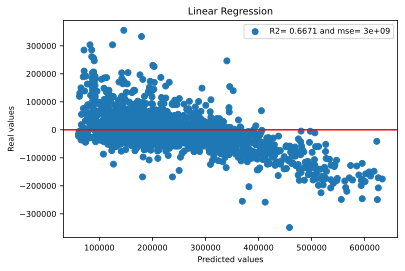

In [41]:
model_test(line_regression_model, 'Linear Regression', X_test, y_test)

## Random Forest Regressor

In [42]:
random_forest_regressor_model = RandomForestRegressor()
random_forest_regressor_model.fit(X_train, y_train)

RandomForestRegressor()

In [43]:
models_dict['Random Forest Regressor'] = random_forest_regressor_model

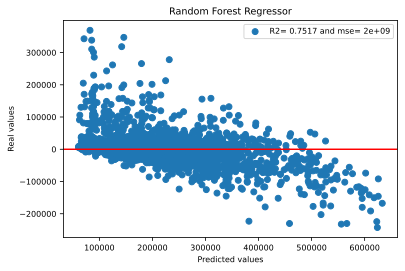

In [44]:
model_test(random_forest_regressor_model,
           'Random Forest Regressor', X_test, y_test)

## Gradient Boosting Regressor

In [45]:
gradient_boosting_regressor_model = GradientBoostingRegressor()
gradient_boosting_regressor_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [46]:
models_dict['Gradient Boosting Regressor'] = gradient_boosting_regressor_model

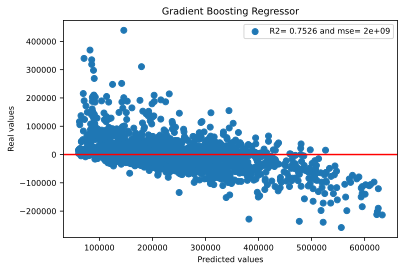

In [47]:
model_test(gradient_boosting_regressor_model,
           'Gradient Boosting Regressor', X_test, y_test)

## LassoCV

In [48]:
lasso_cv_model = LassoCV()
lasso_cv_model.fit(X_train, y_train)

LassoCV()

In [49]:
models_dict['LassoCV'] = lasso_cv_model

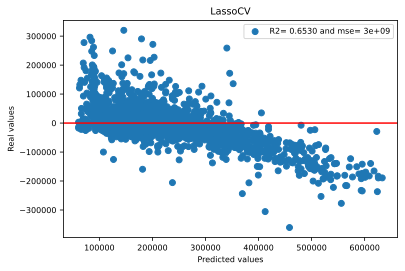

In [50]:
model_test(lasso_cv_model, 'LassoCV', X_test, y_test)

## LGBMRegressor

In [51]:
lgbm_regressor_model = LGBMRegressor()
lgbm_regressor_model.fit(X_train, y_train)

LGBMRegressor()

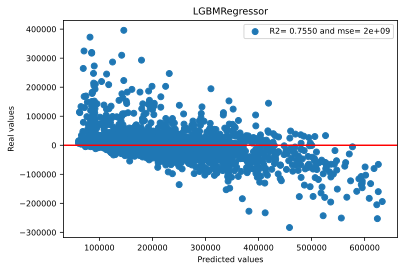

In [56]:
model_test(lgbm_regressor_model, 'LGBMRegressor', X_test, y_test)

#### Tunning LGBMRegressor

In [54]:
lgbm_regressor_model.get_params

<bound method LGBMModel.get_params of LGBMRegressor()>

In [55]:
np.arange(0.01, 0.05, 0.01)

array([0.01, 0.02, 0.03, 0.04])

In [58]:
parameters = [{
    'max_bin': np.arange(90, 120, 10),
    'n_estimators': np.arange(4000, 7000, 1000),
    'learning_rate': np.arange(0.01, 0.05, 0.01)
}]



In [59]:
clf = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=4,
    n_jobs=-1,
)

In [60]:
clf.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'learning_rate': array([0.01, 0.02, 0.03, 0.04]),
                          'max_bin': array([ 90, 100, 110]),
                          'n_estimators': array([4000, 5000, 6000])}],
             scoring='neg_mean_squared_error')

In [61]:
cv_results = pd.DataFrame(clf.cv_results_)
param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score']

cv_results = (cv_results[param_columns + score_columns]
              .sort_values(by=score_columns, ascending=False))

cv_results.head(10)

param_learning_rate param_max_bin param_n_estimators  mean_test_score
6                 0.01           110               4000    -2.088079e+09
7                 0.01           110               5000    -2.109738e+09
0                 0.01            90               4000    -2.110668e+09
3                 0.01           100               4000    -2.116463e+09
8                 0.01           110               6000    -2.128995e+09
1                 0.01            90               5000    -2.131810e+09
4                 0.01           100               5000    -2.135978e+09
2                 0.01            90               6000    -2.150383e+09
5                 0.01           100               6000    -2.153554e+09
15                0.02           110               4000    -2.163152e+09

In [62]:
clf.best_params_

{'learning_rate': 0.01, 'max_bin': 110, 'n_estimators': 4000}

#### Test tunning LGBMRegressor

In [63]:
lgbm_regressor_model = LGBMRegressor(
    max_bin=110,
    num_leaves=4,
    n_estimators=4000,
    learning_rate=0.01
)
lgbm_regressor_model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01, max_bin=110, n_estimators=4000, num_leaves=4)

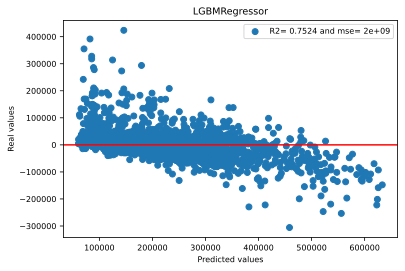

In [64]:
model_test(lgbm_regressor_model, 'LGBMRegressor', X_test, y_test)

In [65]:
models_dict['LGBMRegressor'] = lgbm_regressor_model

### XGBRegressor

In [66]:
xgboost_model = XGBRegressor()
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [67]:
models_dict['XGBRegressor'] = xgboost_model

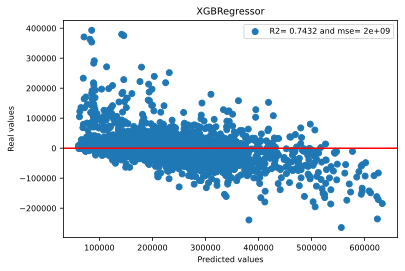

In [68]:
model_test(xgboost_model, 'XGBRegressor', X_test, y_test)

# Резульитаты

найдем лучшее

In [130]:
models_score_test = models_r2(models_dict, X_test, y_test)
models_score_train = models_r2(models_dict, X_train, y_train)

In [131]:
models_score_test[['name', 'r2']]

name        r2
2  Gradient Boosting Regressor  0.752612
4                LGBMRegressor  0.752397
1      Random Forest Regressor  0.751699
5                 XGBRegressor  0.743216
0            Linear Regression  0.667146
3                      LassoCV  0.652968

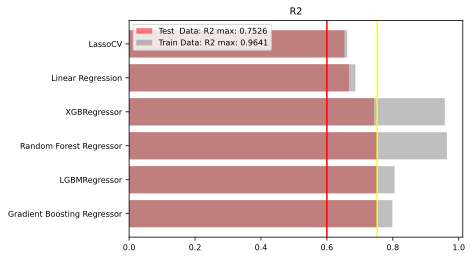

In [132]:
r2_max_test = models_score_test['r2'].max()
r2_max_train = models_score_train['r2'].max()
plt.barh(models_score_test['name'], models_score_test['r2'],
         alpha=0.5, color='red', label=f'Test  Data: R2 max: {r2_max_test:.4f}')
plt.barh(models_score_train['name'], models_score_train['r2'],
         alpha=0.5, color='grey', label=f'Train Data: R2 max: {r2_max_train:.4f}')
plt.title('R2')
plt.legend()
plt.axvline(0.6, color='red')
plt.axvline(r2_max_test, color='yellow')
plt.show()

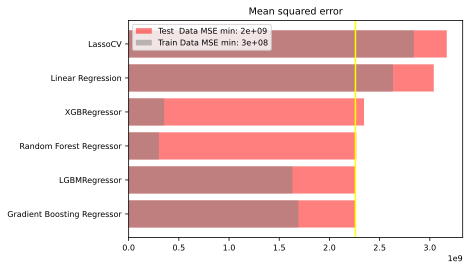

In [133]:
mse_min_test = models_score_test['mse'].min()
mse_min_train = models_score_train['mse'].min()
plt.barh(models_score_test['name'], models_score_test['mse'],
         alpha=0.5, color='red', label=f'Test  Data MSE min: {mse_min_test:.0e}')
plt.barh(models_score_train['name'], models_score_train['mse'],
         alpha=0.5, color='grey', label=f'Train Data MSE min: {mse_min_train:.0e}')
plt.title('Mean squared error')
plt.legend(loc=2)
plt.axvline(mse_min_test, color='yellow')
plt.show()

### Выбор
Gradient Boosting Regressor - не применяем по условию задания!
выберем следуюющий это "LGBMRegressor"

In [134]:
best_model = models_dict['LGBMRegressor']

In [135]:
pd.DataFrame({'name': list(X_train.columns),
              'importances': list(best_model.feature_importances_)})

name  importances
0           Rooms          322
1          Square         1492
2      LifeSquare          927
3   KitchenSquare          815
4           Floor          573
5      HouseFloor          920
6       HouseYear         1502
7       Ecology_1         1254
8        Social_1          614
9        Social_2          199
10       Social_3          364
11   Healthcare_1          740
12    Helthcare_2          143
13        Shops_1          273
14   PriceForMetr         1862

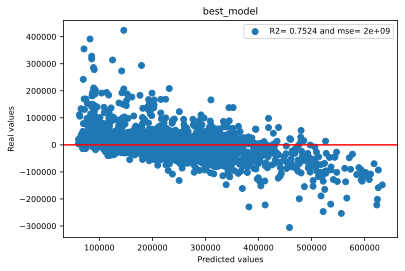

In [136]:
model_test(best_model, 'best_model', X_test, y_test)

### Вывод в файл

In [95]:
test_features = list(X_train.columns)

In [96]:
test[test_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          5000 non-null   uint8  
 1   Square         5000 non-null   float32
 2   LifeSquare     5000 non-null   float32
 3   KitchenSquare  5000 non-null   float32
 4   Floor          5000 non-null   uint8  
 5   HouseFloor     5000 non-null   uint8  
 6   HouseYear      5000 non-null   uint16 
 7   Ecology_1      5000 non-null   float32
 8   Social_1       5000 non-null   uint8  
 9   Social_2       5000 non-null   uint16 
 10  Social_3       5000 non-null   uint8  
 11  Healthcare_1   5000 non-null   float32
 12  Helthcare_2    5000 non-null   uint8  
 13  Shops_1        5000 non-null   uint8  
 14  PriceForMetr   5000 non-null   float64
dtypes: float32(5), float64(1), uint16(2), uint8(7)
memory usage: 190.6 KB


In [97]:
test['Price'] = best_model.predict(test[test_features])

mu = 215623.41 and sigma = 80260.29


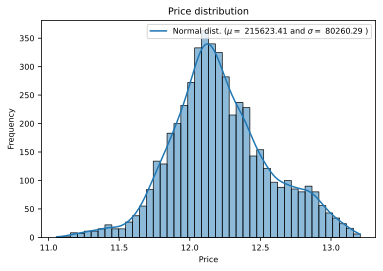

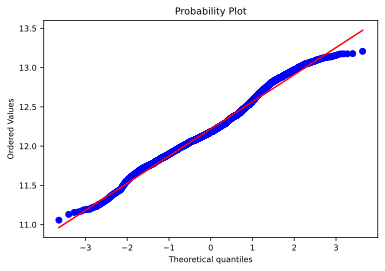

In [119]:
price_log = np.log1p(test['Price'])
#sns.distplot(price_log, fit=norm)
sns.histplot(price_log, kde=True)
#sns.displot(price_log, kde=True)

mu, sigma = norm.fit(test['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

In [137]:
test[['Id', 'Price']].to_csv('DGudilin_predictions.csv', index=None)